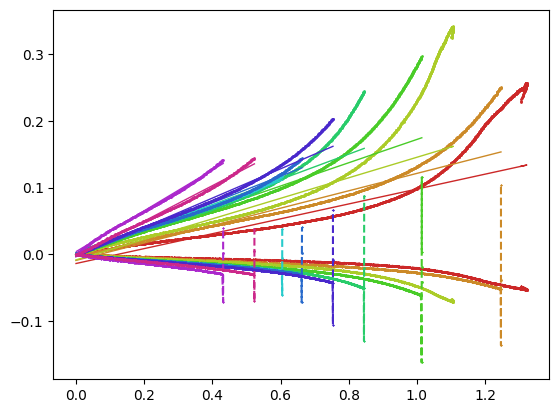

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import colorsys
import os
import pandas as pd

def Second_Derivative_Curve_Smooth(noisyData, smooth_width):
    '''takes list-like input and smooth width to create convolution kernel for calculating the smoothed second order derivative'''
    x1 = np.linspace(-3,3,smooth_width)
    kernel_gaussian2ndDer = (4*x1**2 - 2) * np.exp(-x1**2) / smooth_width * 2
    stress_smoothed_2ndDer = np.convolve(noisyData, kernel_gaussian2ndDer, mode="same")
    return stress_smoothed_2ndDer

def Find_Linear_Region(stress_2ndDer, smoothness_tolerance):
    '''return region of linearity from convolution input as start and end indices'''
    tolerance_index_low, tolerance_index_high = 20, 60 #default values

    for index, i in enumerate(stress_2ndDer):
        if abs(i) > abs(smoothness_tolerance):
            tolerance_index_high = index
            return tolerance_index_low, tolerance_index_high, True
    return tolerance_index_low, tolerance_index_high, False

def hsv_to_hex(h, s, v):
    r, g, b = colorsys.hsv_to_rgb(h, s, v)
    r = int(r * 255)
    g = int(g * 255)
    b = int(b * 255)
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

def Customize_HSV_Value(hue, SV):
    return hsv_to_hex(hue, SV, SV)

def Plot_Dataframe_Axes(df, hue, size):
    color_raw = Customize_HSV_Value(hue, .8)
    color_2ndDer = Customize_HSV_Value(hue, .8)
    color_fit = Customize_HSV_Value(hue, .8)
    index_min, index_max, hasLinearRegion = Find_Linear_Region(df['Stress (N) 2nd Deriv'], 0.03)
    try:
        m, b = np.polyfit(df['Strain (%)'][index_min:index_max], df['Stress (N)'][index_min:index_max], 1)
        converged = True
    except:
        m, b = -1, 0
        converged = False
    # ax.plot(df['Strain (%)'], df['Stress (N)'], 'o', markersize = size, color = color_raw)
    # ax.plot(df['Strain (%)'], df['Stress (N) 2nd Deriv'], 'x', markersize = size, ls = '--',color = color_2ndDer, label = '2nd Deriv')
    # ax.plot(df['Strain (%)'], m*df['Strain (%)'] + b, color = color_fit, label = 'Linear Fit', linewidth = size)
    return m, hasLinearRegion, converged

def Get_Txts_From_Subdirs(dir_path):
    subdir_names = []
    txt_file_paths = []
    sampleNames = []

    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.txt') or file.endswith('.csv'):
                subdir_names.append(os.path.basename(root))
                txt_file_paths.append(os.path.join(root, file))
                sampleNames.append(file.split("\\")[-1].split(".")[-2])

    df = pd.DataFrame({
        'Path': txt_file_paths,
        'File Name': subdir_names,
        'Sample': sampleNames
    })

    return df

def Workup_SS_Data(df_index):
    width = 6
    hue = 1
    thick = []
    YM = []
    toughness = []
    linearRegionFound = []
    converged = []
    strainAtBreak = []
    for file in df_index['Path']:
        df = pd.read_csv(file, sep='\t', names = ['Crosshead', 'Load', 'Time', 'Strain (%)', 'Video Time'], skiprows = 8)
        try:
            thickness = int(file.split("\\")[-2].split("_")[-1])
        except:
            thickness = 30
        if thickness < 5:
            thickness = 30
        crossSection = width * thickness
        df['Stress (N)'] = df['Load'] / crossSection
        df['Stress (N) 2nd Deriv'] = Second_Derivative_Curve_Smooth(df['Stress (N)'], 5)
        area = np.trapz(df['Stress (N)'], df['Strain (%)'])
        m, foundLinear, foundConverge = Plot_Dataframe_Axes(df, hue % 1, 1)
        thick.append(thickness)
        strainAtBreak.append(df['Strain (%)'].iloc[-3])
        toughness.append(area)
        YM.append(m)
        linearRegionFound.append(foundLinear)
        converged.append(foundConverge)
        hue += .1
    df_index['Thickness (mm)'] = thick
    df_index['YM (MPa)'] = YM
    df_index['Strain at Break (%)'] = df['Strain (%)'].iloc[-1] * 100
    df_index['Toughness (J)'] = toughness
    df_index['Linear Region Found'] = linearRegionFound
    df_index['Converged'] = converged

if __name__ == "__main__":
    ## INIT ##
    fig, ax = plt.subplots()
    dirPath = r'CSVs\230313_cbPDMS_oven_100C_45-220min'

    ## DATA PROCESSING ##
    df_index = Get_Txts_From_Subdirs(dirPath)
    Workup_SS_Data(df_index)
    df_index.sort_values(by=['Sample'])
    df_index[['File Name', 'Linear Region Found', 'Converged', 'Thickness (mm)', 'YM (MPa)', 'Toughness (J)', 'Strain at Break (%)']]